The code in this notebook is based on:

- [Huggingface notebook: Text Classification on GLUE](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb)
- [Answer.AI notebook: Finetune ModernBERT on GLUE](https://colab.research.google.com/github/AnswerDotAI/ModernBERT/blob/main/examples/finetune_modernbert_on_glue.ipynb)
- [Huggingface `transformers`: `run_glue.py` script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py)
- [BERT Fine-Tuning Tutorial with PyTorch by Chris McCormick](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

# Fine-Tuning BERT on GLUE - QQP

From [GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding - Wang et al.](https://arxiv.org/pdf/1804.07461):

The Quora Question Pairs dataset is a collection of question pairs from the community
question-answering website Quora. The task is to determine whether a pair of questions are semantically equivalent. As in MRPC, the class distribution in QQP is unbalanced (63% negative), so we
report both accuracy and F1 score. We use the standard test set, for which we obtained private labels
from the authors. We observe that the test set has a different label distribution than the training set.

## 0. Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
from pathlib import Path

import numpy as np
from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)
np.random.seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "qqp"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA A40

==============NVSMI LOG==============

Timestamp                                 : Fri Jan 17 12:45:44 2025
Driver Version                            : 550.90.07
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:05:00.0
    FB Memory Usage
        Total                             : 46068 MiB
        Reserved                          : 665 MiB
        Used                              : 4 MiB
        Free                              : 45401 MiB
    BAR1 Memory Usage
        Total                             : 65536 MiB
        Used                              : 2 MiB
        Free                              : 65534 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## 1. Dataset

In [5]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [6]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

In [7]:
pd.DataFrame(dataset["train"]).sample(10)

,question1,question2,label,idx
215130,Why do some people think that having a baby is...,Why is having a baby a blessing?,1,215130
234600,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,0,234600
118406,Examples of sole proprietorship? The,How are sole proprietorships started?,0,118406
284746,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,1,284746
300683,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,0,300683
311541,I am bald on the right side above my ear becau...,I'm losing my hair from the front and sides an...,0,311541
335211,Which is the best and free small business acco...,Which is the best free accounting software for...,1,335211
124167,How do I calculate e^-0.4 without a calculator...,How do you find 75 percent of a number without...,0,124167
83077,Why do colors look more red in one eye and mor...,Why would one eye see different colors than th...,1,83077
79161,What are sound waves?,What are transverse and longitudinal sound waves?,0,79161


In [8]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([0, 1])
num_labels=2


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

The GLUE benchmark suite keeps the labels for its test dataset secret. This is a common practice in many machine learning benchmarks. By withholding the labels for the test set, it is ensured that the test set is used solely for evaluating the performance of models and models may not be trained on it. This encourages researchers to focus on developing models that generalize well, rather than optimizing for achieving a high score on the specific test set.

In [10]:
pd.DataFrame(dataset["test"]).sample(10)

,question1,question2,label,idx
386632,A single 6-sided die is rolled. What is the pr...,What is the probability of not rolling a numbe...,-1,386632
195065,"Which are some things you know you are bad at,...","Which are some things you know are bad, but st...",-1,195065
176481,What is the application of RLC Circuit?,What are the applications of clipping and clam...,-1,176481
324180,Is a treadmill or a bike more effective for we...,What is the group for assistant locomotive pil...,-1,324180
125094,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,-1,125094
44632,Why did Sanders lose the popular vote by over ...,Why should a Sanders supporter vote for Clinto...,-1,44632
131645,Is the federal reserve a private entity?,What is the US federal reserve?,-1,131645
84989,How is event management as a career for girls?,What is it like for a girl to work in the even...,-1,84989
239573,What are some business ideas with 5 lakh inves...,What are some great business ideas that you wo...,-1,239573
86201,How can you avoid being disconnected on a What...,What does it mean when a WhatsApp call shows b...,-1,86201


The only way to get an evaluation on the testing dataset is to train a model and sent it to the University of New York - which maintains the GLUE benchmark leaderboard - for evaluation. However this option only exists for researches about to publish a paper, therefore we can't do that.

Instead, we will split the training dataset to create a custom test dataset for our experiment. We will keep the validation split as it is.

In [11]:
new_train_test_split = dataset['train'].train_test_split(test_size=0.2)
new_train_test_split

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 291076
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 72770
    })
})

In [12]:
dataset['train'] = new_train_test_split['train']
dataset['test'] = new_train_test_split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 291076
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 72770
    })
})

We now have a test dataset with labels, which is __not__ part of our training data:

In [13]:
pd.DataFrame(dataset["test"]).sample(10)

,question1,question2,label,idx
5133,Since science cannot disprove the existence of...,"What is the most rational evidence, if there i...",0,8123
36609,What is the origin of humans?,What is the origin of human existence?,1,184943
43407,How do I load dollars in my Payoneer master ca...,How do I load Dollars in Payoneer MasterCard f...,1,34898
68793,What would happen if a country doesn't issue c...,If Australia starts giving permanent residency...,0,141671
5036,Why can't I load money on Paytm using SBI Card...,How can I transfer money from an SBI account t...,0,150565
17569,What can I do with unusable headphones?,How are headphones manufactured?,0,126437
35831,Is vacuum energy infinite?,If universe is expanding without a limit and d...,1,344686
40139,Which is the best commuter motorcycle in Mumbai?,What is the best motorcycle for daily commute ...,0,25987
54844,I can't find the Highlights section in my Quor...,When I accidentally press some link on Quora w...,0,319347
10713,How do I get into someone else's Snapchat with...,How do I get someone's Snapchat password?,0,291558


## 2. BERT-base

In [14]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

### 2.1 Tokenization

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [16]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 330
Max length in split='validation': 199
Max length in split='test': 319


In [17]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/72770 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [18]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.DataFrame(tokenized_dataset["train"][:1]).transpose())

,0
question1,What does rappers used to rap?
question2,Why do rappers rap?
label,0
idx,350089
input_ids,"[101, 2054, 2515, 28257, 2109, 2000, 9680, 1029, 102, 2339, 2079, 28257, 9680, 1029, 102]"
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

#### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [19]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,101,2054,2515,28257,2109,2000,9680,1029,102,2339,...,9680,1029,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,2339,2052,1037,6687,6905,2037,2775,1029,102,...,1037,6687,5214,1997.0,8273.0,7741.0,1037.0,2775.0,1029.0,102.0
2,101,2129,2079,1045,2468,2062,5541,1029,102,2129,...,2468,6018,1998,5541.0,1029.0,102.0,NaN,NaN,NaN,NaN


In [20]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,101,2054,2515,28257,2109,2000,9680,1029,102,2339,...,9680,1029,102,0,0,0,0,0,0,0
1,101,2339,2052,1037,6687,6905,2037,2775,1029,102,...,1037,6687,5214,1997,8273,7741,1037,2775,1029,102
2,101,2129,2079,1045,2468,2062,5541,1029,102,2129,...,2468,6018,1998,5541,1029,102,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

### 2.2 Metrics

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [21]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [22]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [23]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task qqp


In [24]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 2.3 Training

In [25]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [28]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [29]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qqp/google-bert_bert-base-uncased'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.300900,0.249854,0.894336,0.858374
2,0.188800,0.257702,0.899926,0.860608
3,0.123200,0.270300,0.906233,0.874591
4,0.085000,0.387041,0.909077,0.877073
5,0.059700,0.436750,0.907593,0.875092


In [30]:
training_summary_bert_base

TrainOutput(global_step=45485, training_loss=0.15151106461307642, metrics={'train_runtime': 4876.4709, 'train_samples_per_second': 298.449, 'train_steps_per_second': 9.327, 'total_flos': 5.145270709758624e+16, 'train_loss': 0.15151106461307642, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [31]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.38704076409339905,
 'eval_accuracy': 0.9090774177590898,
 'eval_f1': 0.8770733012306046,
 'eval_runtime': 38.1364,
 'eval_samples_per_second': 1060.141,
 'eval_steps_per_second': 33.144,
 'epoch': 5.0}

In [32]:
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.3009,0.761352,0.000016,9097,0.249854,0.894336,0.858374,38.1646,1059.358,33.120,NaN,NaN,NaN,NaN,NaN
2,0.1888,15.453444,0.000012,18194,0.257702,0.899926,0.860608,38.1776,1058.999,33.108,NaN,NaN,NaN,NaN,NaN
3,0.1232,12.478412,0.000008,27291,0.270300,0.906233,0.874591,38.1827,1058.856,33.104,NaN,NaN,NaN,NaN,NaN
4,0.0850,0.210776,0.000004,36388,0.387041,0.909077,0.877073,38.1465,1059.861,33.135,NaN,NaN,NaN,NaN,NaN
5,0.0597,0.038839,0.000000,45485,0.436750,0.907593,0.875092,38.1180,1060.654,33.160,4876.4709,298.449,9.327,5.145271e+16,0.151511


### Loss and Evaluation Metrics over Training Steps

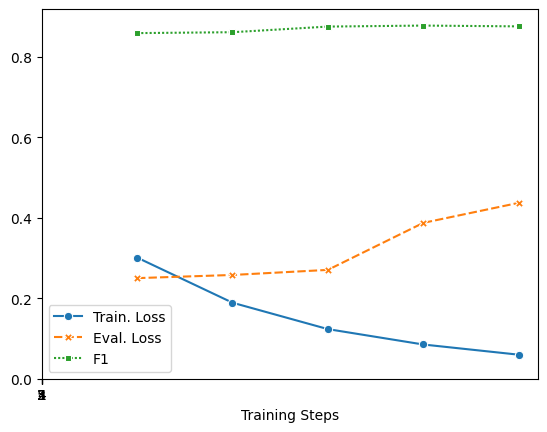

In [33]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 2.4 Evaluation

### Label frequency in test dataset

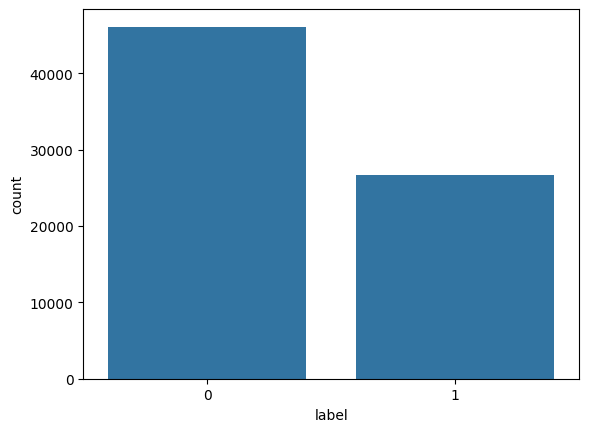

In [34]:
import seaborn as sns

sns.countplot(x='label', data=pd.DataFrame(tokenized_dataset["test"]))

from IPython.display import Markdown, display
display(Markdown("### Label frequency in test dataset"))

The dataset classes seem to be unbalanced.

In [35]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-base-uncased)

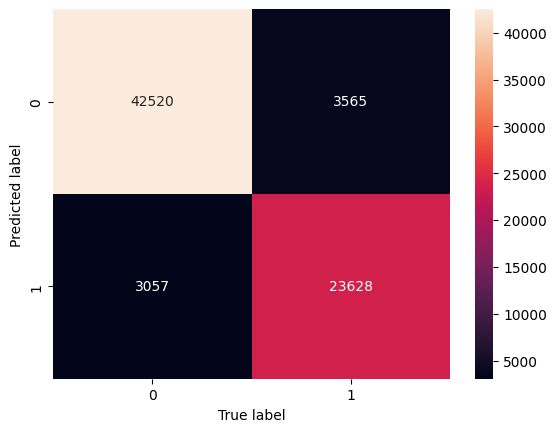

In [36]:
import sklearn.metrics

bert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [37]:
predictions.metrics

{'test_loss': 0.3842650353908539,
 'test_accuracy': 0.9090009619348632,
 'test_f1': 0.8770926908942426,
 'test_runtime': 71.2126,
 'test_samples_per_second': 1021.87,
 'test_steps_per_second': 31.947}

In [38]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    [training_summary_bert_base.metrics["train_runtime"]]
    + list(best_model_evaluation.values())
    + [ predictions.metrics["test_accuracy"], predictions.metrics["test_f1"]],
    index=["train_runtime_s"] + list(best_model_evaluation.keys()) + ["test_accuracy", "test_f1"],
    columns=["our BERT_BASE"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)

# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", "-",  "-",  "-", 0.712]
results["original BERT_LARGE"] = ["-", "-",  "-",  "-",  "-", 0.721]
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,original BERT_LARGE
train_runtime_s,4876.470900,-,-
eval_loss,0.387041,-,-
eval_accuracy,0.909077,-,-
eval_f1,0.877073,-,-
test_accuracy,0.909001,-,-
test_f1,0.877093,0.712,0.721


## 3. BERT-Large

In [39]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-large-uncased"

### 3.1 Tokenization

In [40]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/72770 [00:00<?, ? examples/s]

In [41]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.2 Metrics

In [42]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task qqp


In [43]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 3.3 Training

In [44]:
BATCH_SIZE = 32  # BERT-large might need a smaller batch size

In [45]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

661

In [46]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qqp/google-bert_bert-large-uncased'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.292200,0.244682,0.899233,0.868394
2,0.175400,0.247770,0.906085,0.869308
3,0.108600,0.316815,0.909152,0.877791
4,0.071400,0.453293,0.911674,0.880812
5,0.041400,0.497699,0.910908,0.879636


In [48]:
training_summary_bert_large

TrainOutput(global_step=45485, training_loss=0.13781580007166683, metrics={'train_runtime': 15176.6428, 'train_samples_per_second': 95.896, 'train_steps_per_second': 2.997, 'total_flos': 1.8224392512417235e+17, 'train_loss': 0.13781580007166683, 'epoch': 5.0})

In [49]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.4532926678657532,
 'eval_accuracy': 0.9116744991343062,
 'eval_f1': 0.8808117219051433,
 'eval_runtime': 120.1947,
 'eval_samples_per_second': 336.371,
 'eval_steps_per_second': 10.516,
 'epoch': 5.0}

In [50]:
training_history_bert_large = pd.DataFrame(trainer.state.log_history)
training_history_bert_large.epoch = training_history_bert_large.epoch.astype(int)
training_history_bert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.2922,0.647397,0.000016,9097,0.244682,0.899233,0.868394,120.4063,335.780,10.498,NaN,NaN,NaN,NaN,NaN
2,0.1754,0.904652,0.000012,18194,0.247770,0.906085,0.869308,120.3196,336.022,10.505,NaN,NaN,NaN,NaN,NaN
3,0.1086,2.067322,0.000008,27291,0.316815,0.909152,0.877791,120.2401,336.244,10.512,NaN,NaN,NaN,NaN,NaN
4,0.0714,0.056589,0.000004,36388,0.453293,0.911674,0.880812,120.2892,336.107,10.508,NaN,NaN,NaN,NaN,NaN
5,0.0414,0.008214,0.000000,45485,0.497699,0.910908,0.879636,120.1540,336.485,10.520,15176.6428,95.896,2.997,1.822439e+17,0.137816


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-large-uncased)

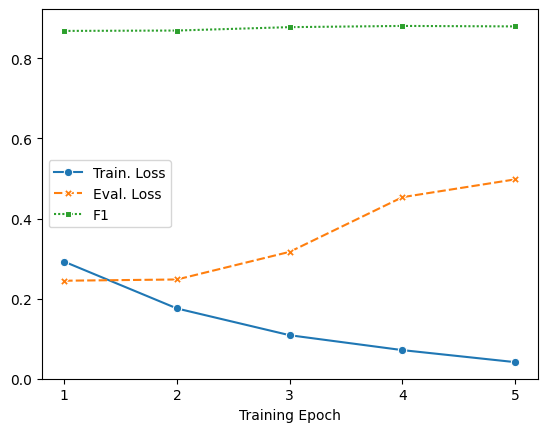

In [51]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [52]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-large-uncased)

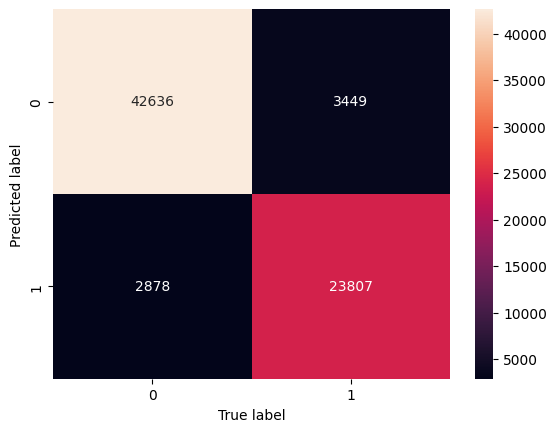

In [53]:
import sklearn.metrics

bert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [54]:
predictions.metrics

{'test_loss': 0.44093307852745056,
 'test_accuracy': 0.9130548302872062,
 'test_f1': 0.8827051778795351,
 'test_runtime': 220.6549,
 'test_samples_per_second': 329.791,
 'test_steps_per_second': 10.31}

In [55]:
display(Markdown(f"### Best Model performance:"))
results["our BERT_LARGE"] = [
    training_summary_bert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    best_model_evaluation["eval_f1"],
    predictions.metrics["test_accuracy"],
    predictions.metrics["test_f1"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,4876.470900,-,15176.642800,-
eval_loss,0.387041,-,0.453293,-
eval_accuracy,0.909077,-,0.911674,-
eval_f1,0.877073,-,0.880812,-
test_accuracy,0.909001,-,0.913055,-
test_f1,0.877093,0.712,0.882705,0.721


## 4. ModernBERT-base

In [56]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-base" 

### 4.1 Tokenization

In [57]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/72770 [00:00<?, ? examples/s]

In [58]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [59]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task qqp


In [60]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [61]:
BATCH_SIZE = 32

In [62]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

647

In [63]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qqp/answerdotai_ModernBERT-base'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.274000,0.234617,0.901435,0.868338
2,0.155200,0.241441,0.909547,0.875235
3,0.077200,0.304623,0.911031,0.879848
4,0.034500,0.509484,0.911303,0.880187
5,0.010300,0.637592,0.910834,0.879829


In [65]:
training_summary_modernbert_base

TrainOutput(global_step=45485, training_loss=0.11026435257432696, metrics={'train_runtime': 3919.9164, 'train_samples_per_second': 371.278, 'train_steps_per_second': 11.604, 'total_flos': 6.547754920953893e+16, 'train_loss': 0.11026435257432696, 'epoch': 5.0})

In [66]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.509341835975647,
 'eval_accuracy': 0.9116002968093,
 'eval_f1': 0.8805640957091297,
 'eval_runtime': 27.0383,
 'eval_samples_per_second': 1495.288,
 'eval_steps_per_second': 46.749,
 'epoch': 5.0}

In [67]:
training_history_modernbert_base = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_base.epoch = training_history_modernbert_base.epoch.astype(int)
training_history_modernbert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.2740,0.329586,0.000064,9097,0.234617,0.901435,0.868338,28.0747,1440.086,45.023,NaN,NaN,NaN,NaN,NaN
2,0.1552,0.399832,0.000048,18194,0.241441,0.909547,0.875235,27.9857,1444.667,45.166,NaN,NaN,NaN,NaN,NaN
3,0.0772,0.162109,0.000032,27291,0.304623,0.911031,0.879848,27.8959,1449.318,45.311,NaN,NaN,NaN,NaN,NaN
4,0.0345,0.057851,0.000016,36388,0.509484,0.911303,0.880187,28.2234,1432.502,44.786,NaN,NaN,NaN,NaN,NaN
5,0.0103,0.000608,0.000000,45485,0.637592,0.910834,0.879829,27.8766,1450.322,45.343,3919.9164,371.278,11.604,6.547755e+16,0.110264


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-base)

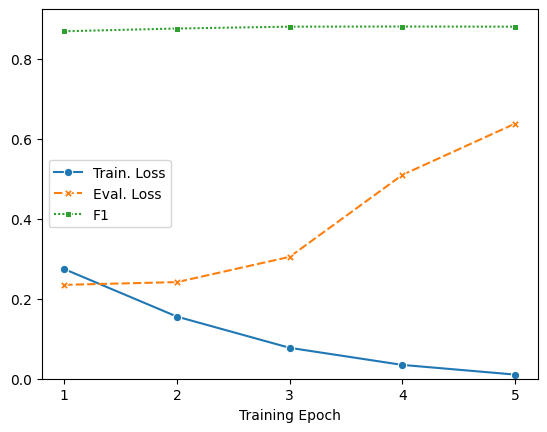

In [68]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [69]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-base)

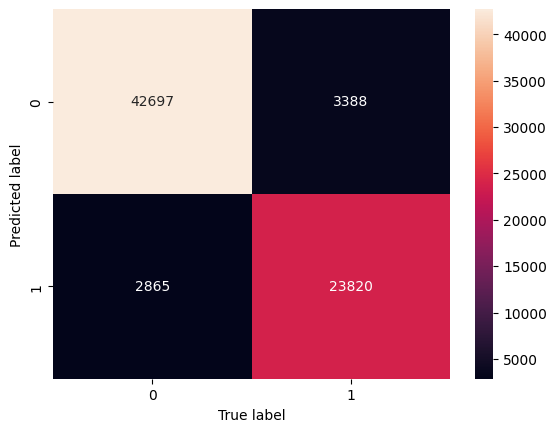

In [70]:
import sklearn.metrics

modernbert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [71]:
predictions.metrics

{'test_loss': 0.4917418658733368,
 'test_accuracy': 0.9140717328569465,
 'test_f1': 0.883973799936912,
 'test_runtime': 51.1759,
 'test_samples_per_second': 1421.957,
 'test_steps_per_second': 44.454}

In [72]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_BASE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    best_model_evaluation["eval_f1"],
    predictions.metrics["test_accuracy"],
    predictions.metrics["test_f1"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,4876.470900,-,3919.916400,15176.642800,-
eval_loss,0.387041,-,0.509342,0.453293,-
eval_accuracy,0.909077,-,0.911600,0.911674,-
eval_f1,0.877073,-,0.880564,0.880812,-
test_accuracy,0.909001,-,0.914072,0.913055,-
test_f1,0.877093,0.712,0.883974,0.882705,0.721


## 5. ModernBERT-Large

In [73]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-large" 

### 4.1 Tokenization

In [74]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/72770 [00:00<?, ? examples/s]

In [75]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [76]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy', 'f1']" as an evaluation metric for the task qqp


In [77]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [78]:
BATCH_SIZE = 32

In [79]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()
torch.cuda.empty_cache()

In [80]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qqp/answerdotai_ModernBERT-large'
--- training_arguments.metric_for_best_model='f1'


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.278200,0.238073,0.898640,0.866602
2,0.159400,0.240330,0.909844,0.877351
3,0.076800,0.303415,0.912664,0.882367
4,0.032500,0.531328,0.914568,0.885272
5,0.009400,0.578968,0.914346,0.884900


In [82]:
training_summary_modernbert_large

TrainOutput(global_step=45485, training_loss=0.11127198433055711, metrics={'train_runtime': 8207.431, 'train_samples_per_second': 177.325, 'train_steps_per_second': 5.542, 'total_flos': 2.0321227100774848e+17, 'train_loss': 0.11127198433055711, 'epoch': 5.0})

In [83]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.5317581295967102,
 'eval_accuracy': 0.9144447192678704,
 'eval_f1': 0.8851326669544715,
 'eval_runtime': 44.1906,
 'eval_samples_per_second': 914.901,
 'eval_steps_per_second': 28.603,
 'epoch': 5.0}

In [84]:
training_history_modernbert_large = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_large.epoch = training_history_modernbert_large.epoch.astype(int)
training_history_modernbert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.2782,0.456533,0.000064,9097,0.238073,0.898640,0.866602,48.8303,827.969,25.886,NaN,NaN,NaN,NaN,NaN
2,0.1594,3.485848,0.000048,18194,0.240330,0.909844,0.877351,48.8113,828.292,25.896,NaN,NaN,NaN,NaN,NaN
3,0.0768,0.080542,0.000032,27291,0.303415,0.912664,0.882367,48.7714,828.970,25.917,NaN,NaN,NaN,NaN,NaN
4,0.0325,0.096827,0.000016,36388,0.531328,0.914568,0.885272,48.7498,829.336,25.928,NaN,NaN,NaN,NaN,NaN
5,0.0094,0.003170,0.000000,45485,0.578968,0.914346,0.884900,48.8628,827.418,25.868,8207.431,177.325,5.542,2.032123e+17,0.111272


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-large)

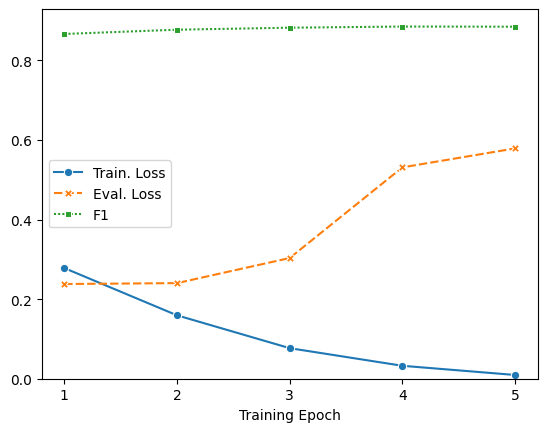

In [85]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [86]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-large)

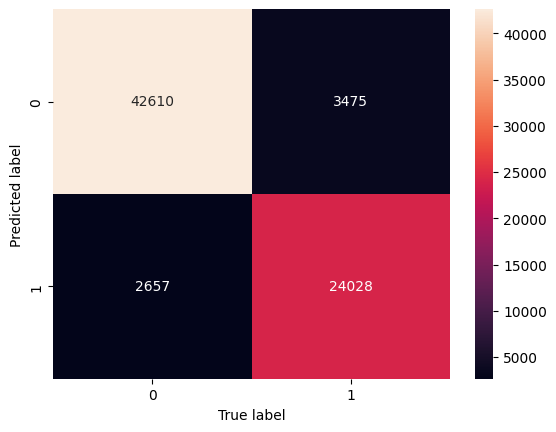

In [87]:
import sklearn.metrics

modernbert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [88]:
predictions.metrics

{'test_loss': 0.5191072225570679,
 'test_accuracy': 0.9157345059777381,
 'test_f1': 0.8868384144090943,
 'test_runtime': 81.6507,
 'test_samples_per_second': 891.236,
 'test_steps_per_second': 27.863}

In [89]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_LARGE"] = [
    training_summary_modernbert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    best_model_evaluation["eval_f1"],
    predictions.metrics["test_accuracy"],
    predictions.metrics["test_f1"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
        "our ModernBERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,4876.470900,-,3919.916400,15176.642800,-,8207.431000
eval_loss,0.387041,-,0.509342,0.453293,-,0.531758
eval_accuracy,0.909077,-,0.911600,0.911674,-,0.914445
eval_f1,0.877073,-,0.880564,0.880812,-,0.885133
test_accuracy,0.909001,-,0.914072,0.913055,-,0.915735
test_f1,0.877093,0.712,0.883974,0.882705,0.721,0.886838


# Summary

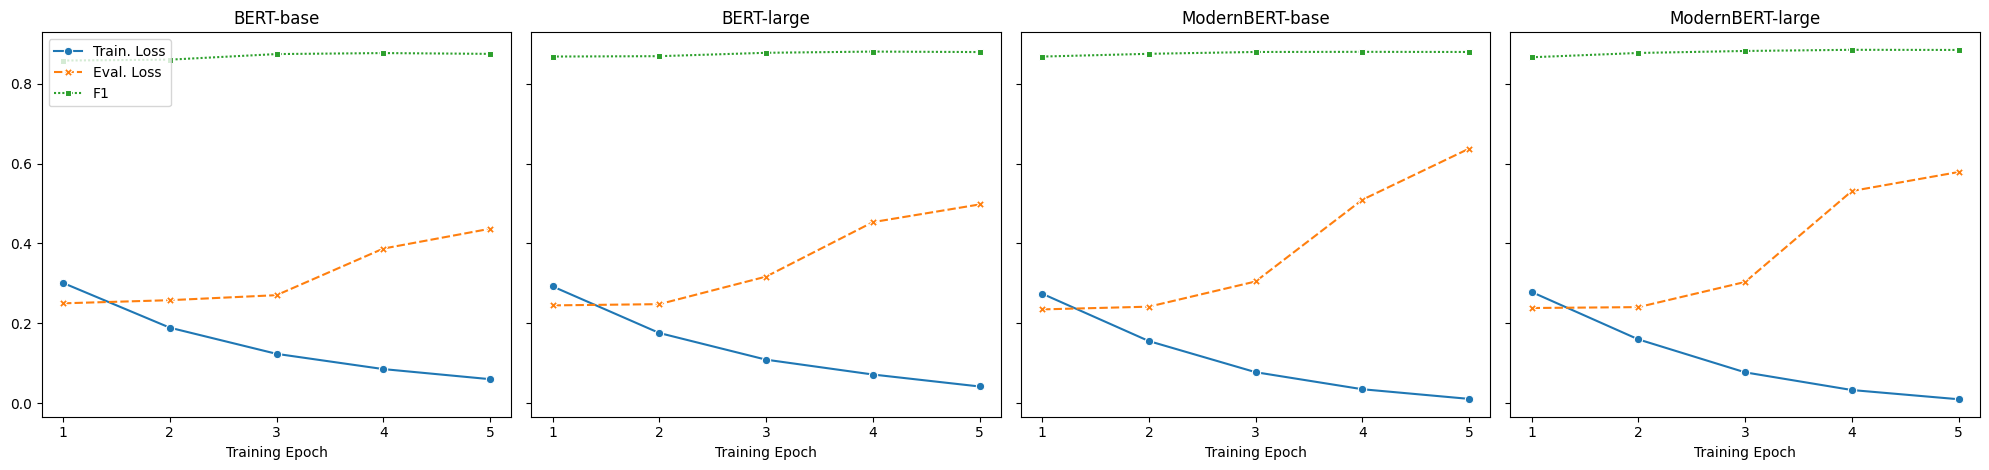

In [90]:
import matplotlib.pyplot as plt

titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
training_histories = [training_history_bert_base, training_history_bert_large, training_history_modernbert_base, training_history_modernbert_large]

fig, axes = plt.subplots(ncols=len(training_histories), sharey=True)

def draw_loss_eval_plot(title, history, ax):
    data = history[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
    data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "F1"]
    data = data[:-1]
    data = pd.melt(data, ['Training Epoch']).dropna()

    plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True, ax=ax)
    plot.set_ylabel("")
    plot.set(xticks=list(set(history.epoch)))
    plot.legend(title="", loc='upper left')
    plot.set_title(title)

for title, history, ax in zip(titles, training_histories, axes):
    draw_loss_eval_plot(title, history, ax)

for ax in axes[1:]:
    ax.get_legend().remove()

fig.set_figwidth(20)
fig.tight_layout()

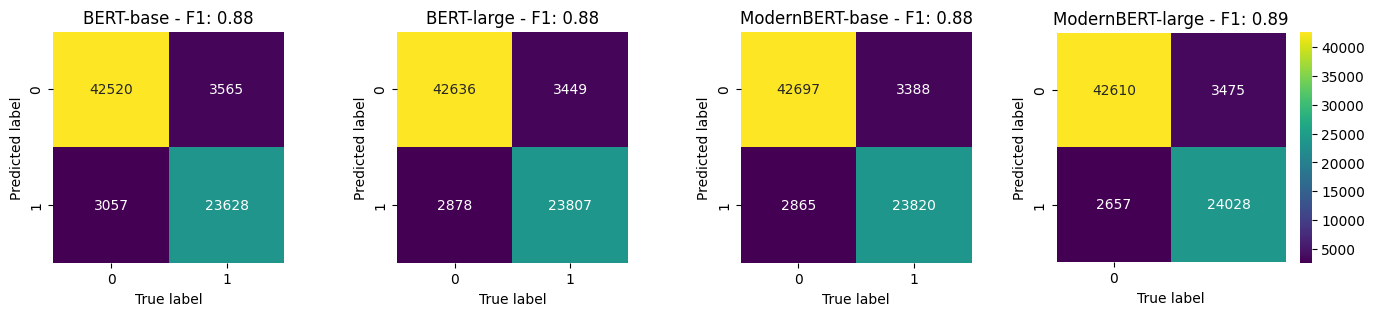

In [91]:
titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
our_results = results.loc["test_f1"].drop("original BERT_BASE").drop("original BERT_LARGE")
titles = [title + " - " + f"F1: {acc:.2f}" for title, acc in zip(titles, our_results)]
cms = [bert_base_cm, bert_large_cm, modernbert_base_cm, modernbert_large_cm]

fig, axes = plt.subplots(ncols=len(cms),  figsize=(3,3))

def draw_confusion_matrix_plot(title, cm, ax):
    include_cbar = title == titles[-1]
    plot = sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="viridis", cbar=include_cbar, ax=ax)
    plot.set_xlabel("True label")
    plot.set_ylabel("Predicted label")
    plot.set_title(title)

for title, history, ax in zip(titles, cms, axes):
    draw_confusion_matrix_plot(title, history, ax)

fig.set_figwidth(17)

In [92]:
results

,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,4876.470900,-,3919.916400,15176.642800,-,8207.431000
eval_loss,0.387041,-,0.509342,0.453293,-,0.531758
eval_accuracy,0.909077,-,0.911600,0.911674,-,0.914445
eval_f1,0.877073,-,0.880564,0.880812,-,0.885133
test_accuracy,0.909001,-,0.914072,0.913055,-,0.915735
test_f1,0.877093,0.712,0.883974,0.882705,0.721,0.886838


In [93]:
speedup = results["our BERT_BASE"]["train_runtime_s"] / results["our ModernBERT_BASE"]["train_runtime_s"] 
speedup

np.float64(1.2440242092918103)

On our self-generated test set we achieved higher F1 scores than the original BERT paper achieved on the real GLUE QQP test set. Similar to other GLUE tasks we see that `ModernBERT-base` achieves scores comparable to `BERT-Large`. However the difference here is negligible. Still we see that `ModernBERT-base` has a higher runtime performance than `BERT-base` with a speedup of `1.24`